# InternVL3-8B: Independent Single-Turn Bank Statement Extraction (8-bit Quantized)

**Protocol**: Two independent single-turn prompts + Python parsing/filtering

**Key Insight**: Multi-turn conversation degrades accuracy. LLM filtering mixes up rows. Use Python for filtering!

**Model**: InternVL3-8B with 8-bit quantization for V100 compatibility

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
Turn 1: Image + Prompt → Full Table (fresh context, dynamic markdown example)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit)
3. **Turn 1 (LLM)**: Extract full markdown table using **dynamic example** matching detected column structure
4. **Python Parsing**: Parse markdown → Filter for debits → Extract schema fields

### Critical Features:
- ❌ **No Turn 2** - LLM filtering mixes up rows!
- ✅ **Python filtering** - Reliable debit/credit separation
- ✅ **Dynamic examples** - Adapt to 3/4/5 column formats
- ✅ **Markdown teaching** - InternVL3 understands markdown format for alignment
- ✅ **Tax accuracy** - Correct Debit/Credit separation critical for identifying purchases

### Why This Works:
- **Turn 0**: Clean context → accurate header identification
- **Turn 1**: Clean context + dynamic example → accurate table extraction
- **Python**: Reliable filtering for debit transactions (what taxpayer PAID)

### Model: InternVL3-8B
- **8-bit quantization** for V100 memory efficiency
- Higher capacity than 2B variant
- Strong vision-language capabilities
- Simple API with `model.chat()` method
- V100-optimized: CPU offload enabled


In [ ]:
# Cell 1: Imports

from pathlib import Path
import random
import math

import numpy as np
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

# IPython display for rendering markdown
from IPython.display import display, Markdown


# Set Random Seed for Reproducibility

In [2]:
# Cell 3: Set random seed

from common.reproducibility import set_seed
set_seed(42)

✅ Random seed set to 42 for reproducibility


# Load the model

In [ ]:
# Cell 5: Load InternVL3-8B model with 8-bit quantization
# Update this path to your local InternVL3-8B model
# model_id = "/home/jovyan/shared_PTM/InternVL3-8B"
model_id = "/home/jovyan/nfs_share/models/InternVL3-8B"

print("🔧 Loading InternVL3-8B with 8-bit quantization for V100 GPUs...")

# 8-bit quantization config for V100 memory efficiency
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    llm_int8_enable_fp32_cpu_offload=True,  # CRITICAL: Allow CPU offload when needed for V100
)

# Load model with 8-bit quantization and device_map
model = AutoModel.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",  # Required for quantization
    trust_remote_code=True,
    torch_dtype=torch.float16,  # Explicit dtype for V100 compatibility
    low_cpu_mem_usage=True,     # Additional memory optimization
).eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True,
    use_fast=False
)

# Set generation config on model
model.config.max_new_tokens = 2000

# Fix pad_token_id to suppress warnings
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✅ InternVL3-8B model loaded successfully with V100-optimized 8-bit quantization!")
print(f"✅ Model distributed across devices: {model.hf_device_map}")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Quantization: 8-bit with CPU offload enabled")


# Load the image

In [4]:
# Cell 7: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_amount_balance.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_date_grouped_cont.png"
imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/low_contrast_fixed.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/nab_classic_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/westpac_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/transaction_summary.png"



# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/images/image_009.png"
print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for multi-turn compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

📁 Loading image...
✅ Image loaded: (676, 960)
✅ Images list created with 1 image(s)


🖼️  Bank statement image:


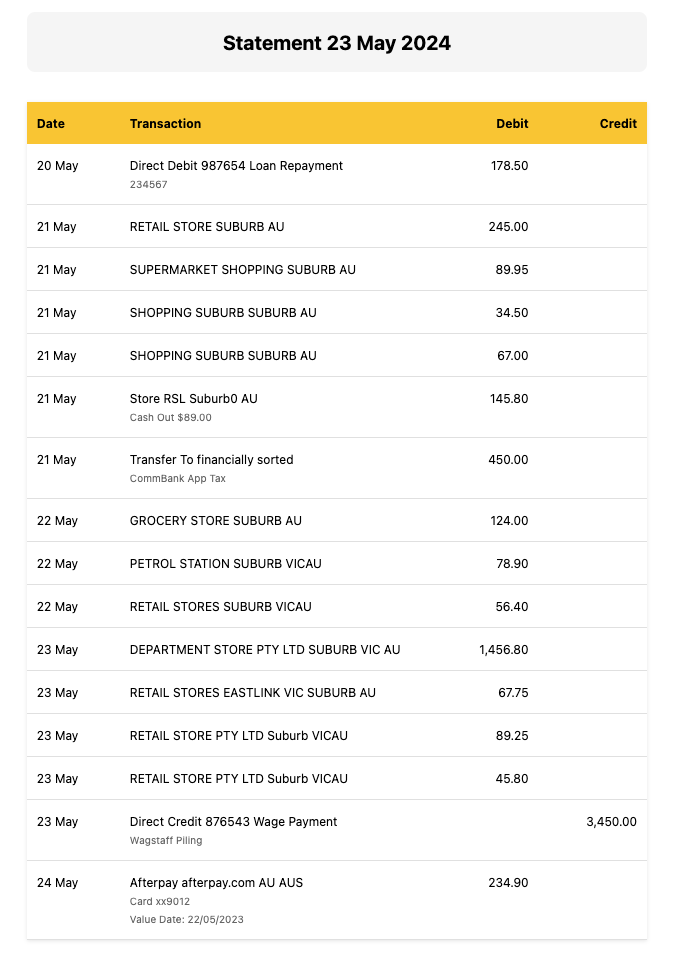

In [5]:
# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

In [ ]:
# Cell 7.5: Image preprocessing for InternVL3 (Official implementation)

# Official InternVL3 image preprocessing (from docs)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.229)

def build_transform(input_size):
    """Build image transformation pipeline with ImageNet normalization."""
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """Find the closest aspect ratio from target ratios based on image dimensions."""
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    """
    Dynamically preprocess image by splitting into tiles based on aspect ratio.
    
    Args:
        image: PIL Image
        min_num: Minimum number of tiles
        max_num: Maximum number of tiles (12 for 2B model, 24 for 8B model)
        image_size: Size of each tile (448 for InternVL3)
        use_thumbnail: Whether to include thumbnail image
    
    Returns:
        List of PIL Image tiles
    """
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # Generate target aspect ratios
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # Find best aspect ratio
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # Calculate target dimensions
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # Resize and split into tiles
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    
    assert len(processed_images) == blocks
    
    # Add thumbnail if requested
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    """
    Load and preprocess image for InternVL3.
    
    Args:
        image_file: Path to image or PIL Image object
        input_size: Size of each tile (448 for InternVL3)
        max_num: Max number of tiles (12 for 2B model, 24 for 8B model)
    
    Returns:
        pixel_values: Preprocessed tensor ready for model.chat()
    """
    # Handle both path string and PIL Image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    
    # Build transform and preprocess
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(img) for img in images]
    pixel_values = torch.stack(pixel_values)
    
    return pixel_values

print("✅ InternVL3 image preprocessing functions defined")
print(f"💡 Using max_num=12 tiles for 2B model (standard resolution)")
print(f"💡 Image preprocessing: ImageNet normalization + dynamic tiling")


# Bank Statement Extraction Protocol
- Turn 0: Identify actual table headers
- Turn 1: Extract full table using dynamic markdown example
- Python: Parse, filter, and extract schema fields

In [6]:
# Cell 9: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers
# First, identify the actual column headers used in this specific bank statement

prompt = """
Look at the transaction table in this bank statement image.

IMPORTANT STRUCTURAL NOTE:
Some bank statements show dates as section headings with multiple transactions underneath.
If you see this structure, remember that each transaction needs its explicit date in the final output.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

# Create message structure for Llama
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": prompt,
            },
        ],
    }
]

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with Llama-3.2-Vision...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with Llama-3.2-Vision...


In [ ]:
# Cell 11: Turn 0 - Execute and parse headers (InternVL3-8B version)

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3-8B (8-bit quantized)...")

# Load and preprocess image for InternVL3
pixel_values = load_image(imageName, input_size=448, max_num=12)

# Move to correct device and dtype for InternVL3-8B with 8-bit quantization
# CRITICAL: Use float16 for 8-bit quantized models (not bfloat16)
vision_device = 'cuda:0'  # Vision model is on GPU 0
model_dtype = torch.float16
pixel_values = pixel_values.to(dtype=model_dtype, device=vision_device)

# Generate response using chat() method
cleanedOutput = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=prompt,
    generation_config={
        "max_new_tokens": 2000,
        "do_sample": False  # Greedy decoding for consistency
    }
)

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(cleanedOutput)
print("=" * 60)

# CRITICAL: Parse the identified headers for use in subsequent turns
# Extract column names from the response
header_lines = [line.strip() for line in cleanedOutput.split('\n') if line.strip()]
identified_headers = []

# Look for numbered list or bullet points
for line in header_lines:
    # Remove common list markers
    cleaned = line.lstrip('0123456789.-•* ').strip()
    
    # Strip markdown bold formatting
    cleaned = cleaned.replace('**', '').replace('__', '')
    
    # Skip section headers (lines ending with colon)
    if cleaned.endswith(':'):
        continue
    
    # Skip long sentences (likely explanatory text, not headers)
    if len(cleaned) > 40:
        continue
        
    if cleaned and len(cleaned) > 2:  # Ignore very short strings
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store headers for use in subsequent turns
table_headers = identified_headers

# Save the table headers
output_path = Path("internvl3_8b_table_headers.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput)

print(f"\n✅ Table headers saved to: {output_path}")
print("💡 These LITERAL header names will be used in Turn 1 prompts")


In [ ]:
# # Cell 11: Turn 0 - Execute and parse headers
# # Process the input using the CORRECT multi-turn pattern
# # Based on: https://medium.com/data-science/chat-with-your-images-using-multimodal-llms-60af003e8bfa

# textInput = processor.apply_chat_template(
#     messageDataStructure, add_generation_prompt=True
# )

# # CRITICAL: Use named parameter 'images=' with list
# inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

# # Generate response with deterministic parameters
# output = model.generate(
#     **inputs,
#     max_new_tokens=2000,
#     do_sample=False,
#     temperature=None,
#     top_p=None,
# )

# # CRITICAL: Trim input tokens from output (this is the key to clean responses!)
# generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
# cleanedOutput = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

# print("✅ Response generated successfully!")
# print("\n" + "=" * 60)
# print("TURN 0 - IDENTIFIED TABLE HEADERS:")
# print("=" * 60)
# print(cleanedOutput)
# print("=" * 60)

# # CRITICAL: Parse the identified headers for use in subsequent turns
# # Extract column names from the response
# header_lines = [line.strip() for line in cleanedOutput.split('\n') if line.strip()]
# identified_headers = []

# # Look for numbered list or bullet points
# for line in header_lines:
#     # Remove common list markers
#     cleaned = line.lstrip('0123456789.-•* ').strip()
    
#     # Strip markdown bold formatting
#     cleaned = cleaned.replace('**', '').replace('__', '')
    
#     # Skip section headers (lines ending with colon)
#     if cleaned.endswith(':'):
#         continue
    
#     # Skip long sentences (likely explanatory text, not headers)
#     if len(cleaned) > 40:
#         continue
        
#     if cleaned and len(cleaned) > 2:  # Ignore very short strings
#         identified_headers.append(cleaned)

# print(f"\n📋 Parsed {len(identified_headers)} column headers:")
# for i, header in enumerate(identified_headers, 1):
#     print(f"  {i}. '{header}'")

# # Store headers for use in subsequent turns
# table_headers = identified_headers

# # Save the table headers
# output_path = Path("llama_table_headers.txt")
# with output_path.open("w", encoding="utf-8") as text_file:
#     text_file.write(cleanedOutput)

# print(f"\n✅ Table headers saved to: {output_path}")
# print("💡 These LITERAL header names will be used in Turn 1 & 2 prompts")

## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**

In [8]:
# Cell 13: Pattern Matching - Map headers to generic columns
# Pattern Matching: Map extracted headers to generic concepts
# This handles variety in bank statement column naming conventions

# Pattern keywords for each concept (in priority order)
DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']

# NEW: Pattern for single-column transaction formats (e.g., "Amount" instead of separate Debit/Credit)
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords.
    
    Matching strategy:
    1. Exact match (case-insensitive)
    2. Substring match (only for patterns with length > 2 to avoid false positives)
    """
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match (only for patterns longer than 2 chars)
    for pattern in patterns:
        if len(pattern) > 2:  # Avoid false positives like 'cr' matching 'description'
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching on extracted headers
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')

# NEW: First try to match a generic "Amount" column (for 4-column formats)
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)

# Use amount_col as fallback if no separate debit/credit columns exist
# This handles formats like: Date | Description | Amount | Balance
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback='Balance')

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")
if amount_col:
    print(f"\n💡 Single-column format detected: '{amount_col}' used for both debit and credit")
print("=" * 60)
print("\n✅ These literal column names will be used in Turn 1 and Turn 2")
print("💡 Adjust patterns above if matching fails for your bank statement format")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Transaction', 'Debit', 'Credit']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Transaction'
  Debit       → 'Debit'
  Credit      → 'Credit'
  Balance     → 'Balance'

✅ These literal column names will be used in Turn 1 and Turn 2
💡 Adjust patterns above if matching fails for your bank statement format


### 🔑 Independent Single-Turn Pattern (NOT Multi-Turn Conversation)

**CRITICAL INSIGHT**: Multi-turn conversation accumulates context and degrades accuracy.

We use **two independent single-turn prompts**, each with fresh context:

#### Key Principles:

1. **No Conversation History**: Each turn is completely independent
2. **Fresh Image Attention**: Each turn processes the image directly
3. **No Context Accumulation**: Prevents attention dilution
4. **Headers as Parameters**: Turn 0 headers used to generate dynamic examples for Turn 1
5. **Python Filtering**: LLM filtering mixes up rows - Python is reliable

#### Message Structure for Each Turn:

Every turn uses fresh structure:
```python
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "<prompt with dynamic example>"}
        ]
    }
]
```

**No assistant responses in history. No conversation accumulation.**

#### Why This Works Better:

- **Turn 0**: Clean context → accurate header identification
- **Turn 1**: Clean context + dynamic example → accurate table extraction  
- **Python**: Reliable parsing and filtering (no row mixing!)

Each turn has **full attention** on the image, not diluted by conversation history.

In [9]:
# Cell 15: NO conversation history (independent turns)
# 
# CRITICAL: We do NOT use conversation history in this notebook.
# Each turn is completely independent with fresh context.
#
# Why? Multi-turn conversation accumulates context and degrades accuracy:
# - Turn 0: ~50 tokens → accurate
# - Turn 1 with history: ~350 tokens → attention diluted → less accurate
# - Turn 2 with history: ~2000 tokens → attention heavily diluted → row mixing!
#
# Instead: 
# - Turn 0: Fresh context → headers
# - Turn 1: Fresh context + dynamic example → full table
# - Python: Parse and filter (no LLM confusion!)

print("✅ Independent turn approach - NO conversation history")
print("💡 Each turn has fresh context with direct image access")
print("🐍 Python handles all filtering - no LLM row mixing!")

✅ Independent turn approach - NO conversation history
💡 Each turn has fresh context with direct image access
🐍 Python handles all filtering - no LLM row mixing!


## Generate Column Aware Extraction Prompt

In [ ]:
# Cell 17: Generate Column Aware Extraction Prompt

# Build the header string using LITERAL names from Turn 0
header_string = " | ".join(table_headers)

# Build separator row with proper alignment indicators
# Date and Description columns: left-aligned (:---)
# Debit, Credit, Balance columns: right-aligned (---:)
separator_parts = []
for h in table_headers:
    h_lower = h.lower()
    # Right-align numeric columns
    if any(keyword in h_lower for keyword in ['debit', 'credit', 'balance', 'amount', 'total']):
        separator_parts.append('---:')
    else:
        # Left-align text columns (Date, Transaction, Description, etc.)
        separator_parts.append(':---')

separator_row = " | ".join(separator_parts)

# Build dynamic example rows based on detected column structure
# CRITICAL: Examples must emphasize correct Debit/Credit column alignment!
def build_dynamic_example(headers, date_col, desc_col, debit_col, credit_col, balance_col):
    """Generate example rows matching detected column structure.
    
    Emphasizes correct Debit/Credit alignment for tax purposes:
    - Debits (purchases/withdrawals) = money OUT = what taxpayer PAID
    - Credits (deposits/income) = money IN = NOT purchases
    """
    
    # Check if we have separate debit/credit columns
    has_separate_debit_credit = (debit_col in headers and credit_col in headers and debit_col != credit_col)
    
    rows = []
    
    if has_separate_debit_credit:
        # 5-column format: Emphasize Debit vs Credit with clear examples
        
        # Example 1: DEBIT transaction (purchase/withdrawal) - money OUT
        row1 = []
        for h in headers:
            if h == date_col:
                row1.append("15 Jan")
            elif h == desc_col:
                row1.append("ATM Withdrawal City Branch")
            elif h == debit_col:
                row1.append("200.00")  # Amount in DEBIT column
            elif h == credit_col:
                row1.append("")  # Credit column EMPTY
            elif h == balance_col:
                row1.append("$1,500.00 CR")
            else:
                row1.append("")
        rows.append(" | ".join(row1))
        
        # Example 2: CREDIT transaction (deposit) - money IN
        row2 = []
        for h in headers:
            if h == date_col:
                row2.append("16 Jan")
            elif h == desc_col:
                row2.append("Salary Employer Name Ref 12345")
            elif h == debit_col:
                row2.append("")  # Debit column EMPTY
            elif h == credit_col:
                row2.append("3,500.00")  # Amount in CREDIT column
            elif h == balance_col:
                row2.append("$5,000.00 CR")
            else:
                row2.append("")
        rows.append(" | ".join(row2))
        
        # Example 3: Another DEBIT transaction (purchase)
        row3 = []
        for h in headers:
            if h == date_col:
                row3.append("17 Jan")
            elif h == desc_col:
                row3.append("Online Purchase Store Name")
            elif h == debit_col:
                row3.append("150.00")  # Amount in DEBIT column
            elif h == credit_col:
                row3.append("")  # Credit column EMPTY
            elif h == balance_col:
                row3.append("$4,850.00 CR")
            else:
                row3.append("")
        rows.append(" | ".join(row3))
        
    else:
        # 4-column format: Single Amount column
        row1 = []
        for h in headers:
            if h == date_col:
                row1.append("15 Jan")
            elif h == desc_col:
                row1.append("ATM Withdrawal City Branch")
            elif h == debit_col:  # This is the Amount column
                row1.append("200.00")
            elif h == balance_col:
                row1.append("$1,500.00 CR")
            else:
                row1.append("")
        rows.append(" | ".join(row1))
        
        row2 = []
        for h in headers:
            if h == date_col:
                row2.append("16 Jan")
            elif h == desc_col:
                row2.append("Salary Employer Name Ref 12345")
            elif h == debit_col:  # This is the Amount column
                row2.append("3,500.00")
            elif h == balance_col:
                row2.append("$5,000.00 CR")
            else:
                row2.append("")
        rows.append(" | ".join(row2))
    
    return rows

def build_multiline_rule(headers):
    """Generate multi-line extraction rule using ACTUAL column structure from Turn 0."""
    num_cols = len(headers)
    
    # Find actual Debit, Credit, and Balance columns by name
    debit_idx = None
    credit_idx = None
    balance_idx = None
    
    for i, header in enumerate(headers):
        h_lower = header.lower()
        if any(p in h_lower for p in ["debit", "withdrawal", "paid", "spent", "dr"]):
            debit_idx = i
        if any(p in h_lower for p in ["credit", "deposit", "received", "cr"]):
            credit_idx = i
        if any(p in h_lower for p in ["balance", "bal"]):
            balance_idx = i
    
    if debit_idx is None or credit_idx is None:
        return "Multi-line: combine description lines into single row."
    
    def format_aligned_table(rows):
        """Format rows with properly aligned vertical pipes."""
        if not rows:
            return []
        
        num_cols = len(rows[0])
        
        # Calculate max width for each column
        col_widths = [0] * num_cols
        for row in rows:
            for i, val in enumerate(row):
                col_widths[i] = max(col_widths[i], len(val))
        
        # Find last non-empty column index
        last_col = 0
        for row in rows:
            for i, val in enumerate(row):
                if val:
                    last_col = max(last_col, i)
        
        # Ensure empty MIDDLE columns have minimum width
        for i in range(1, last_col):  # Skip first column, only middle columns
            if col_widths[i] == 0:
                col_widths[i] = 7
        
        # Format each row with proper alignment
        formatted = []
        for row in rows:
            # Determine how many columns to include
            end_col = last_col + 2 if last_col < len(row) - 1 else last_col + 1
            end_col = min(end_col, len(row))
            
            # Pad each column value to its width
            parts = []
            for i in range(end_col):
                val = row[i] if i < len(row) else ""
                parts.append(val.ljust(col_widths[i]))
            
            line = " | ".join(parts)
            
            # CRITICAL: If first column is empty, add leading spaces to align pipes
            if not row[0]:
                line = " " * col_widths[0] + " | " + " | ".join(parts[1:])
            
            formatted.append(line)
        
        return formatted
    
    # Create example rows using ACTUAL column positions
    # Credit example (amount in credit_idx position)
    credit_rows = [[""] * num_cols for _ in range(3)]
    credit_rows[0][0] = "a date"
    credit_rows[0][1] = "line 1"
    credit_rows[0][credit_idx] = "85.50"
    # Add Balance column value if it exists
    if balance_idx is not None:
        credit_rows[0][balance_idx] = "$1,085.50 CR"
    credit_rows[1][0] = ""  # Empty date for continuation
    credit_rows[1][1] = "line 2"
    credit_rows[2][0] = "a date"
    credit_rows[2][1] = "line 1 line 2"
    credit_rows[2][credit_idx] = "85.50"
    # Add Balance column value if it exists
    if balance_idx is not None:
        credit_rows[2][balance_idx] = "$1,085.50 CR"
    
    # Debit example (amount in debit_idx position)
    debit_rows = [[""] * num_cols for _ in range(3)]
    debit_rows[0][0] = "a date"
    debit_rows[0][1] = "line 1"
    debit_rows[0][debit_idx] = "150.00"
    # Add Balance column value if it exists
    if balance_idx is not None:
        debit_rows[0][balance_idx] = "$850.00 CR"
    debit_rows[1][0] = ""  # Empty date for continuation
    debit_rows[1][1] = "line 2"
    debit_rows[2][0] = "a date"
    debit_rows[2][1] = "line 1 line 2"
    debit_rows[2][debit_idx] = "150.00"
    # Add Balance column value if it exists
    if balance_idx is not None:
        debit_rows[2][balance_idx] = "$850.00 CR"
    
    # Format both examples
    credit_fmt = format_aligned_table(credit_rows)
    debit_fmt = format_aligned_table(debit_rows)
    
    # Build rule with LABELED examples using actual header names
    rule = f"""  {headers[credit_idx]} example:
       {credit_fmt[0]}
       {credit_fmt[1]}
    you must extract it as:
       {credit_fmt[2]}

  {headers[debit_idx]} example:
       {debit_fmt[0]}
       {debit_fmt[1]}
    you must extract it as:
       {debit_fmt[2]}"""
    
    return rule

# Generate dynamic example rows
example_rows = build_dynamic_example(table_headers, date_col, desc_col, debit_col, credit_col, balance_col)

# Build complete example table with proper alignment
example_table = f"""| {header_string} |
| {separator_row} |
""" + "\n".join([f"| {row} |" for row in example_rows])

# Generate dynamic multi-line rule
multiline_rule = build_multiline_rule(table_headers)

# OPTION D: STRONGER COLUMN REINFORCEMENT
follow_up_prompt = f"""
Extract the transaction table from this bank statement image in markdown format.

Example showing the format I want:

{example_table}

## CRITICAL: COLUMN ALIGNMENT

Before extracting ANY row, locate the header row with these column names:
{" | ".join(table_headers)}

For EACH transaction, you must check which column the amount appears under:

**Step-by-step process:**
1. Find the header row
2. Look at the transaction row
3. Draw an imaginary vertical line from the amount UP to the header
4. Read which header the amount aligns with
5. Put the amount in that SAME column in your markdown table

**Column placement rules:**
- Amount aligns with "{debit_col}" header → put amount in {debit_col} column, leave {credit_col} EMPTY
- Amount aligns with "{credit_col}" header → put amount in {credit_col} column, leave {debit_col} EMPTY

**Do NOT guess based on description text. Use visual alignment ONLY.**

## OTHER RULES

**Multi-line transactions:** Combine description lines into single row:
{multiline_rule}

**Empty columns:** Leave empty (|  |)

**Output:** Markdown table only, no explanations

"""

print("\n" + "=" * 60)
print("Turn 1 Extraction Prompt (Option D):")
print("=" * 60)
print(f"\n{follow_up_prompt}")
print("=" * 60 + "\n")


In [ ]:
# Cell 17.5: Turn 1 - Extract full table (InternVL3-8B version, INDEPENDENT fresh context)

print("🤖 Generating response with InternVL3-8B (8-bit quantized)...")

# CRITICAL: Reload image for fresh context (independent turn, not continuing conversation)
pixel_values = load_image(imageName, input_size=448, max_num=12)

# Move to correct device and dtype
# CRITICAL: Use float16 for 8-bit quantized models (not bfloat16)
pixel_values = pixel_values.to(dtype=torch.float16, device='cuda:0')

# Generate response using chat() method with dynamic prompt
cleanedOutput2 = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=follow_up_prompt,  # Dynamic prompt with column-aware examples from Cell 19
    generation_config={
        "max_new_tokens": 2000,
        "do_sample": False
    }
)

print("\n✅ Turn 1 extraction complete!")

# Display the extracted table as rendered markdown for easy visual verification
print("\n" + "=" * 60)
print("TURN 1 - EXTRACTED MARKDOWN TABLE:")
print("=" * 60)
display(Markdown(cleanedOutput2))
print("=" * 60)

# Save the markdown table
output_path = Path("internvl3_8b_markdown_table_extraction.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput2)

print(f"\n✅ Markdown table saved to: {output_path}")


In [ ]:
# Cell 17.5: Turn 1 - Extract full table (INDEPENDENT, fresh context)

# # CRITICAL: Create FRESH message structure (NOT appending to conversation history)
messageDataStructure_turn1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": follow_up_prompt}
        ]
    }
]

print("Generating response with Llama-3.2-Vision...")

# Process with FRESH context
textInput = processor.apply_chat_template(
    messageDataStructure_turn1, add_generation_prompt=True
)

# CRITICAL: Use named parameter 'images=' with list
inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

# Generate response
output = model.generate(
    **inputs,
    max_new_tokens=2000,
    do_sample=False,
    temperature=None,
    top_p=None,
)

# CRITICAL: Trim input tokens from output
generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
cleanedOutput2 = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

print("\nTurn 1 extraction complete!")

# Display the extracted table as rendered markdown for easy visual verification
print("\n" + "=" * 60)
print("TURN 1 - EXTRACTED MARKDOWN TABLE:")
print("=" * 60)
display(Markdown(cleanedOutput2))
print("=" * 60)

# Save the markdown table
output_path = Path("llama_markdown_table_extraction.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput2)

print(f"\nMarkdown table saved to: {output_path}")

## Python Parsing and Filtering

Parse the Turn 1 markdown table, filter for debit transactions, and extract schema fields using Python.

In [ ]:
# Cell 19: Parse Turn 1 markdown table and filter for debits (Python)
import re
from datetime import datetime

def parse_markdown_table(markdown_text):
    """Parse markdown table into list of dictionaries.
    
    CRITICAL: Must preserve empty columns for correct Debit/Credit alignment!
    """
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    # Find header row (first line with pipes)
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            # Skip separator rows (contain only pipes, hyphens, and spaces)
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:  # Has actual content, not just separators
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    # Parse headers - KEEP empty values to preserve column positions
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    # Remove leading/trailing empty strings from pipe delimiters
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    # Filter out any remaining empty headers
    headers = [h for h in header_parts if h]
    
    print(f"🔍 Debug: Parsed {len(headers)} headers: {headers}")
    
    # Parse data rows (skip header and separator)
    rows = []
    for idx, line in enumerate(lines[header_idx + 1:], start=header_idx+1):
        if '|' not in line:
            continue
            
        # Skip separator rows
        cleaned = line.replace("|", "").replace("-", "").replace(" ", "").replace(":", "")
        if not cleaned:
            continue
        
        # Parse values - KEEP empty values to preserve column positions!
        value_parts = [v.strip() for v in line.split('|')]
        # Remove leading/trailing empty strings from pipe delimiters
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        
        print(f"🔍 Debug row {idx}: {len(value_parts)} values: {value_parts}")
        
        # Match to headers length
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
        else:
            print(f"⚠️  Row {idx} mismatch: {len(value_parts)} values vs {len(headers)} headers - SKIPPED")
    
    return rows

def filter_debit_transactions(rows, debit_col):
    """Filter rows to only those with debit (purchase) amounts.
    
    CRITICAL: For tax purposes, we only want transactions where taxpayer PAID money (debits).
    """
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, '').strip()
        # Include row if debit column has a value (not empty)
        if debit_value:
            debit_rows.append(row)
    
    return debit_rows

def extract_schema_fields(rows, date_col, desc_col, debit_col):
    """Extract fields in universal.yaml schema format."""
    if not rows:
        return {
            'TRANSACTION_DATES': 'NOT_FOUND',
            'LINE_ITEM_DESCRIPTIONS': 'NOT_FOUND',
            'TRANSACTION_AMOUNTS_PAID': 'NOT_FOUND',
            'STATEMENT_DATE_RANGE': 'NOT_FOUND'
        }
    
    # Extract lists
    dates = []
    descriptions = []
    amounts = []
    
    for row in rows:
        date = row.get(date_col, '').strip()
        desc = row.get(desc_col, '').strip()
        amount = row.get(debit_col, '').strip()
        
        if date:
            dates.append(date)
        if desc:
            descriptions.append(desc)
        if amount:
            amounts.append(amount)
    
    # Calculate statement date range - use literal date format from image
    # No parsing, no year assumption - just "earliest date - latest date"
    date_range = 'NOT_FOUND'
    if dates:
        # Use first and last date as-is (same format as in the image)
        date_range = f"{dates[0]} - {dates[-1]}"
    
    return {
        'TRANSACTION_DATES': ' | '.join(dates) if dates else 'NOT_FOUND',
        'LINE_ITEM_DESCRIPTIONS': ' | '.join(descriptions) if descriptions else 'NOT_FOUND',
        'TRANSACTION_AMOUNTS_PAID': ' | '.join(amounts) if amounts else 'NOT_FOUND',
        'STATEMENT_DATE_RANGE': date_range
    }

print("=" * 60)
print("PARSING TURN 1 MARKDOWN TABLE:")
print("=" * 60)

# Parse the full markdown table from Turn 1
all_rows = parse_markdown_table(cleanedOutput2)

print(f"\n📊 Parsed {len(all_rows)} total transactions from Turn 1 markdown table")

if all_rows:
    # Show sample parsed row
    print(f"\n🔍 Sample parsed row:")
    for key, value in all_rows[0].items():
        print(f"  {key}: '{value}'")

# Filter to only debit (purchase) transactions - Python filtering, not LLM!
debit_rows = filter_debit_transactions(all_rows, debit_col)

print(f"\n💰 Filtered to {len(debit_rows)} debit transactions (taxpayer purchases)")
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):")
print("=" * 60)
for i, row in enumerate(debit_rows, 1):
    print(f"\nTransaction {i}:")
    print(f"  {date_col}: {row.get(date_col, '')}")
    print(f"  {desc_col}: {row.get(desc_col, '')}")
    print(f"  {debit_col}: {row.get(debit_col, '')}")

# Extract schema fields using the LITERAL column names from pattern matching
schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS (TAX-RELEVANT DATA):")
print("=" * 60)
for field, value in schema_fields.items():
    print(f"{field}: {value}")
print("=" * 60)

# Save to file with InternVL3 prefix
output_path = Path("internvl3_8b_extracted_fields.txt")
with output_path.open("w", encoding="utf-8") as f:
    for field, value in schema_fields.items():
        f.write(f"{field}: {value}\n")

print(f"\n✅ Schema fields saved to: {output_path}")
print(f"💡 Fields extracted from columns: '{date_col}' | '{desc_col}' | '{debit_col}'")
print(f"🎯 Success: Python parsing + filtering from Turn 1 markdown table")
